# Import Data

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import functions

ModuleNotFoundError: No module named 'functions'

In [ ]:
# import data
df = pd.read_csv('dataframes/pos_df.csv')
df.head()

In [ ]:
# import exp metadata
df_exps = pd.read_csv('dataframes/pos_df_exps.csv')
df_exps.head()

In [ ]:
# import lipid metadata
df_meta2 = pd.read_csv('dataframes/pos_lipids_df_meta2.csv')
df_meta2.head()

In [ ]:
# rename columns
df_p = functions.df_p(df, df_exps)
df_p.head()

In [ ]:
df_ccc = df_p[['CAS9', 'CAV', 'CAVIN']]
df_ccc.head()

# PCA

## Standardize Data (across row)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
df_standardized = df_ccc.T
exps = df_standardized.index

x = df_standardized.values
print(x.shape)
x = StandardScaler().fit_transform(x)

# check random column for standardization (mean=0, standard deviation=1)
x.shape, np.mean(x[:,20]), np.std(x[:,20])

## PCA - DataFrame

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_lipids = PCA(n_components=3)
pca=pca_lipids.fit_transform(x)

In [ ]:
# create dataframe with principal components
df_pca = pd.DataFrame(pca)
pcs = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3']
df_pca.columns=pcs
df_pca['Mutation'] = exps
df_pca

## Explained Variance

In [ ]:
ev = pca_lipids.explained_variance_ratio_
print('Explained variance per principal component:')
print('PC 1: {}\nPC 2: {}\nPC 3: {}'.format(ev[0],ev[1],ev[2]))

In [ ]:
plt.figure(figsize=(4,5))
plt.bar(
    x=['PC 1', 'PC 2', 'PC 3'],
    height=ev
)
plt.title('Explained Variance')
plt.savefig('graphs/cas_cav_cavin/pca/ExplainedVarianceGraph.png', dpi=300, bbox_inches='tight')

## PCA

In [14]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

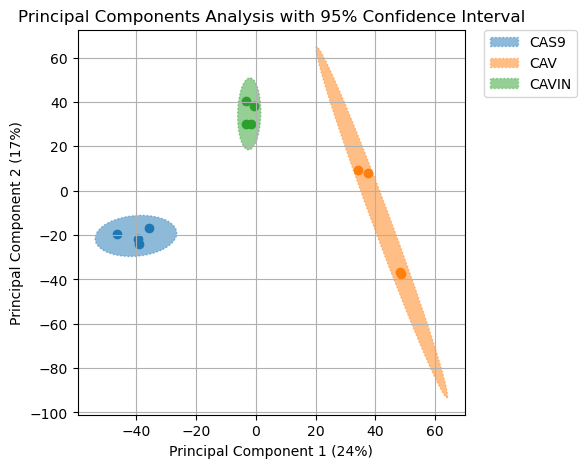

In [15]:
i = 0
fig, ax_nstd = plt.subplots(figsize=(5,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for protein in df_pca['Mutation'].unique():
    x = df_pca[df_pca['Mutation'] == protein]['Principal Component 1']
    y = df_pca[df_pca['Mutation'] == protein]['Principal Component 2']
    
    ax_nstd.scatter(x, y, color=colors[i])
    confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=protein, alpha=0.5, facecolor=colors[i], edgecolor=colors[i], linestyle=':')
    i += 1


ax_nstd.grid()
ax_nstd.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax_nstd.set_title('Principal Components Analysis with 95% Confidence Interval')
ax_nstd.set_xlabel('Principal Component 1 (24%)')
ax_nstd.set_ylabel('Principal Component 2 (17%)')
plt.show()
ax_nstd.figure.savefig('graphs/cas_cav_cavin/pca/PCA.png', dpi=300, bbox_inches='tight')

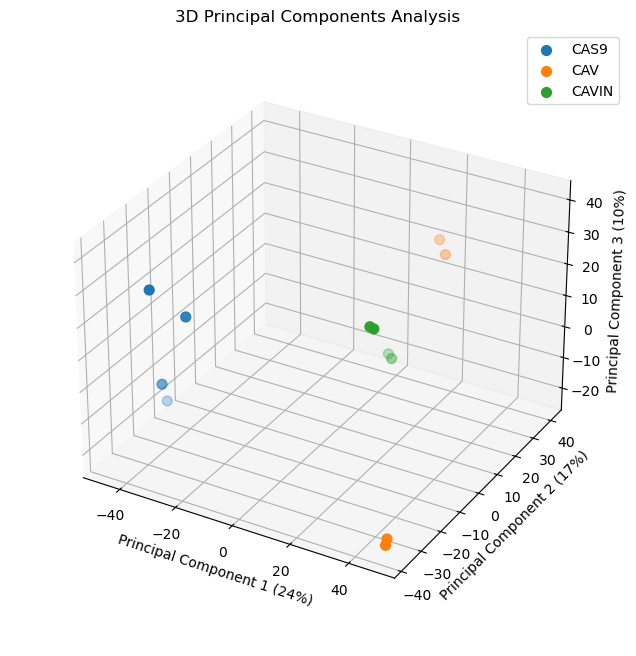

In [16]:
i = 0
fig = plt.figure(figsize=(8,8))
ax_nstd = fig.add_subplot(projection='3d')
ax_nstd.set_box_aspect(aspect=None, zoom=0.9)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for protein in df_pca['Mutation'].unique():
    x = df_pca[df_pca['Mutation'] == protein]['Principal Component 1']
    y = df_pca[df_pca['Mutation'] == protein]['Principal Component 2']
    z = df_pca[df_pca['Mutation'] == protein]['Principal Component 3']
    
    ax_nstd.scatter(x, y, z, color=colors[i], label=protein, s=50)
#     confidence_ellipse(x, y, ax_nstd, n_std=3,
#                    label=protein, alpha=0.5, facecolor=colors[i], edgecolor=colors[i], linestyle=':')
    i += 1


ax_nstd.grid()
ax_nstd.legend()
ax_nstd.set_title('3D Principal Components Analysis')
ax_nstd.set_xlabel('Principal Component 1 (24%)')
ax_nstd.set_ylabel('Principal Component 2 (17%)')
ax_nstd.set_zlabel('Principal Component 3 (10%)')
plt.show()
ax_nstd.figure.savefig('graphs/cas_cav_cavin/pca/3D_PCA.png', dpi=300, bbox_inches='tight')

# Head Group Analysis

## Donut Charts

### All Head Groups

In [17]:
h = functions.norm_long(df_meta2, df_ccc, var='Head Group 2', renamed_var='Head Group', norm_var=False)
# h.head()

In [18]:
chart_list = []

# create selection tool
click = alt.selection_point(fields=['Head Group'])

# create head group legend
heads = alt.Chart(h).mark_point().encode(
    x=alt.X('Head Group').axis(labelAngle=-45),
    color=alt.condition(click, 'Head Group', alt.value('lightgray')),
    ).add_params(click).properties(title={'text':[], 'subtitle':'Head Group'})

for ptn in h['Mutation'].unique():
    source = h[h['Mutation'] == ptn]
    
    donut = alt.Chart(source).mark_arc(innerRadius=100).encode(
        theta='mean(Fraction):Q',
        color=alt.condition(click, 'Head Group', alt.value('lightgray'), scale=alt.Scale(scheme='tableau20'), legend=None),
        opacity = alt.condition(click, alt.value(1), alt.value(0.1)),
        tooltip=['Head Group', 'mean(Fraction)']
    ).add_params(click).properties(
        width=300,
        title={'text':[], 'subtitle':ptn}
    )
    
    chart_list.append(donut)

d = alt.hconcat(*chart_list) & heads
d = d.properties(title=alt.Title('Average Percentage of Head Group'))
d.save('graphs/cas_cav_cavin/head_group/Donut_Charts_AllHG.png', ppi=300)
d

alt.VConcatChart(...)

### No PE/PC/SM/PS

In [19]:
h_dropped = functions.norm_long(df_meta2, df_ccc, var='Head Group 2', renamed_var='Head Group', drop_var=['PC', 'PE', 'PS', 'SM'], norm_var=False)

In [20]:
chart_list = []

# create selection tool
click = alt.selection_point(fields=['Head Group'])

# create head group legend
heads = alt.Chart(h_dropped).mark_point().encode(
    x=alt.X('Head Group').axis(labelAngle=-45),
    color=alt.condition(click, 'Head Group', alt.value('lightgray')),
    ).add_params(click).properties(title={'text':[], 'subtitle':'Head Group'})

for ptn in h_dropped['Mutation'].unique():
    source = h_dropped[h_dropped['Mutation'] == ptn]
    
    donut = alt.Chart(source).mark_arc(innerRadius=100).encode(
        theta='mean(Fraction):Q',
        color=alt.condition(click, 'Head Group', alt.value('lightgray'), scale=alt.Scale(scheme='tableau20'), legend=None),
        opacity = alt.condition(click, alt.value(1), alt.value(0.1)),
        tooltip=['Head Group', 'mean(Fraction)']
    ).add_params(click).properties(
        width=300,
        title={'text':[], 'subtitle':ptn}
    )
    
    chart_list.append(donut)

d = alt.hconcat(*chart_list) & heads
d = d.properties(title={'text':['Average Percentage of Head Group'],  'subtitle':['PE/PC/PS/SM removed']})
d.save('graphs/cas_cav_cavin/head_group/Donut_Charts_NoPEPCPSSM.png', ppi=300)
d

alt.VConcatChart(...)

## Heatmap

In [21]:
hhg = alt.Chart(h).mark_rect(stroke='white').encode(
    x='Mutation:N',
    y=alt.Y('Head Group:N', sort=alt.EncodingSortField(field='Fraction', order='descending')),
    color='mean(Fraction):Q',
    tooltip=['Mutation', 'Head Group', 'mean(Fraction)']
).properties(
    title = "Head Group Distribution",
    width=500,
    height=500
)
hhg.save('graphs/cas_cav_cavin/head_group/Heatmap_AllHG.png', ppi=300)
hhg

alt.Chart(...)

In [22]:
hhg = alt.Chart(h_dropped).mark_rect(stroke='white').encode(
    x='Mutation:N',
    y=alt.Y('Head Group:N', sort=alt.EncodingSortField(field='Fraction', order='descending')),
    color='mean(Fraction):Q',
    tooltip=['Mutation', 'Head Group', 'mean(Fraction)']
).properties(
    title = {'text': "Head Group Distribution", "subtitle":"PE/PC/PS/SM removed"},
    width=500,
    height=500
)
hhg.save('graphs/cas_cav_cavin/head_group/Heatmap_NoPEPCPSSM.png', ppi=300)
hhg

alt.Chart(...)

## Z-Score

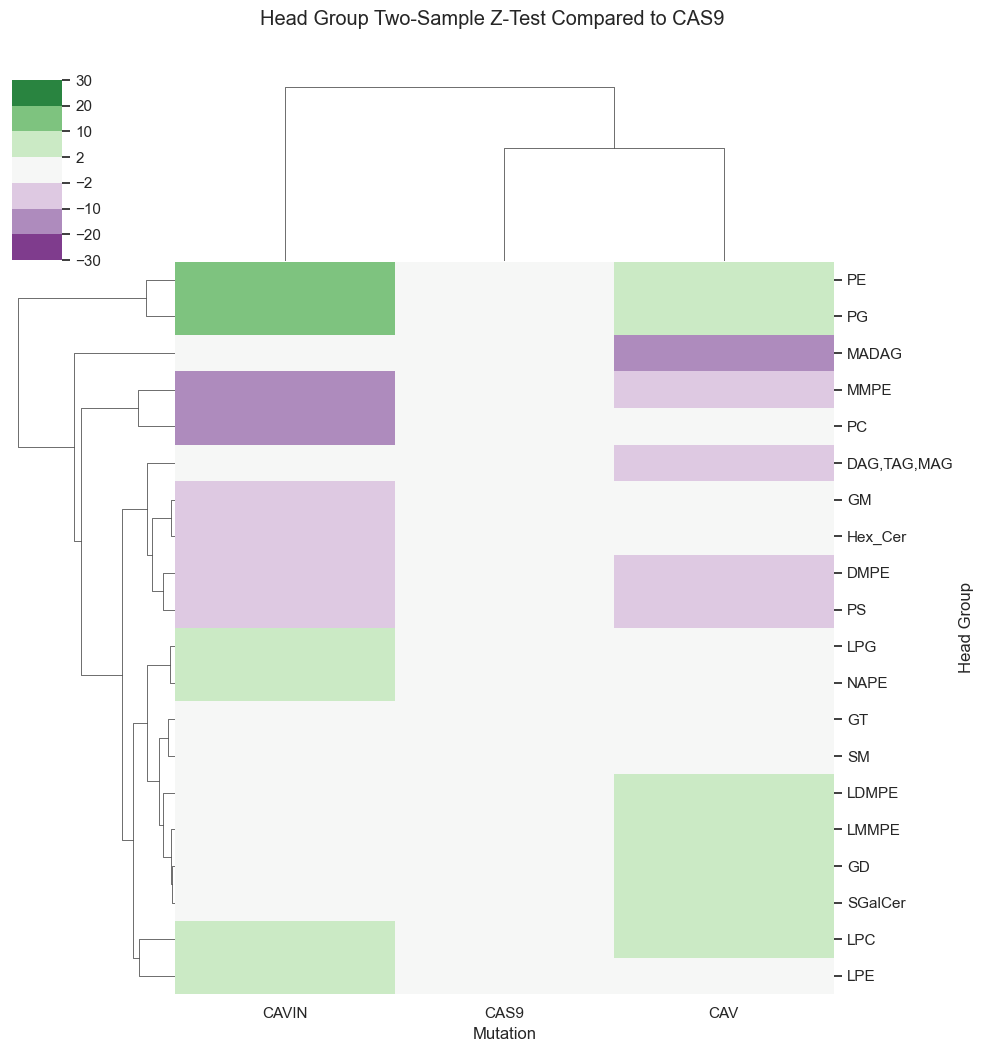

In [23]:
hg_z = functions.z_score(df_meta2,
                         df_ccc,
                         var = 'Head Group 2',
                         renamed_var='Head Group',
                         ctrl = 'CAS9',
                         row_cluster=True,
                         outlier=False)

In [24]:
# hg_z.to_csv('graphs/cas_cav_cavin/head_group/Z-ScoreTable_AllHG.csv')
hg_z

Mutation,CAS9,CAV,CAVIN
Head Group,,,
"DAG,TAG,MAG",0.0,-3.513243,-0.585010
DMPE,0.0,-2.992602,-3.848909
GD,0.0,3.835373,1.175904
GM,0.0,-0.028175,-2.356993
GT,0.0,1.652953,1.071009
Hex_Cer,0.0,0.414400,-2.397415
LDMPE,0.0,2.866853,0.095508
LMMPE,0.0,3.301788,1.384913
LPC,0.0,6.316480,5.333831


# Chain Length Analysis

In [25]:
# long form of dataset for histogram w/ error bars
ptnstd = functions.norm_long(df_meta2, df_ccc, 'Acyl Chain Length')
# ptnstd.head()

In [26]:
# groupby table for bimodal gaussian
ptns = functions.groupby_norm(df_meta2, df_ccc, 'Acyl Chain Length', norm_var=False).reset_index()
# ptns.head()

## Histogram w/ Bimodal Gaussian

In [27]:
from scipy.optimize import curve_fit 

### Side by Side

In [28]:
chart_list = []
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

for protein in ptnstd['Mutation'].unique():
    source = ptnstd[ptnstd['Mutation'] == protein]
    
    # create error bars
    err = alt.Chart(source).mark_errorbar(extent='stdev').encode(
        x='Acyl Chain Length:Q',
        y='Fraction:Q',
    )
    
    # create histogram
    bar = alt.Chart(source).mark_bar().encode(
        x='Acyl Chain Length:Q',
        y=alt.Y('mean(Fraction):Q').scale(domain=[0,.26]),
    ).properties(title=protein)
    
    # create gaussian
    x = ptns[(ptns['Acyl Chain Length'] % 2 == 0)]['Acyl Chain Length']
    y = ptns[protein].loc[x.index]
    
    # expected vals
    x1 = x[(x < 51) & (x >= 20)]
    y1 = ptns[protein].loc[x1.index]
    x2 = x[(x >= 51)]
    y2 = ptns[protein].loc[x2.index]
    
    n1 = sum(y1)
    mean1 = sum(x1*y1)/n1                  
    sigma1 = sum(y1*(x1-mean1)**2)/n1
    a1 = max(y1)
    
    n2 = sum(y2)                         
    mean2 = sum(x2*y2)/n2                  
    sigma2 = sum(y2*(x2-mean2)**2)/n2
    a2=max(y2)
    
    expected = [mean1, sigma1, a1, mean2, sigma2, a2]
    # print(protein, expected)
    
    popt,pcov = curve_fit(bimodal,x,y,p0=expected)
    
    xx = np.linspace(10, 60, 500)
    
    s = pd.DataFrame({'Acyl Chain Length':xx, 'y':bimodal(xx, *popt)})
    
    gaus = alt.Chart(s).mark_line(color='red').encode(
        x='Acyl Chain Length:Q',
        y='y:Q'
    )
    
    text1 = alt.Chart({'values':[{}]}).mark_text(
        align="left", baseline="top"
    ).encode(
        x=alt.value(5),  # pixels from left
        y=alt.value(5),  # pixels from top
        text=alt.value([f"mu1: {popt[0]:.3f}", f"sigma1: {popt[1]:.3f}", f"a1: {popt[2]:.3f}"])
    )
    
    text2 = alt.Chart({'values':[{}]}).mark_text(
        align="left", baseline="top"
    ).encode(
        x=alt.value(230),  # pixels from left
        y=alt.value(5),  # pixels from top
        text=alt.value([f"mu2: {popt[3]:.3f}", f"sigma2: {popt[4]:.3f}", f"a2: {popt[5]:.3f}"])
    )
    
    # append to chart list
    chart = bar + err + gaus + text1 + text2
    
    chart_list.append(chart)
    
ss_bimodal = alt.hconcat(*chart_list[:])
ss_bimodal.save('graphs/cas_cav_cavin/chain_length/Histogram_SidebySide.png', ppi=300)
ss_bimodal

alt.HConcatChart(...)

### Overlapping

In [29]:
chart_list_o = []
line_chart_only = []
# list of colors + counter to move to next color
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
i=0
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

for protein in ptnstd['Mutation'].unique():
    source = ptnstd[ptnstd['Mutation'] == protein]
    
    # create error bars
    err = alt.Chart(source).mark_errorbar(extent='stdev', opacity=0.3).encode(
        x='Acyl Chain Length:Q',
        y='Fraction:Q',
        color=alt.Color('Mutation:N').scale(range=colors)
    )
    
    # create histogram
    bar = alt.Chart(source).mark_bar(opacity=0.3).encode(
        x='Acyl Chain Length:Q',
        y=alt.Y('mean(Fraction):Q').scale(domain=[0,.26]),
        color=alt.Color('Mutation:N').scale(range=colors)
    )
    
    # create gaussian
    x = ptns[(ptns['Acyl Chain Length'] % 2 == 0)]['Acyl Chain Length']
    y = ptns[protein].loc[x.index]
    
    # expected vals
    x1 = x[(x < 51) & (x >= 20)]
    y1 = ptns[protein].loc[x1.index]
    x2 = x[(x >= 51)]
    y2 = ptns[protein].loc[x2.index]
    
    n1 = sum(y1)
    mean1 = sum(x1*y1)/n1                  
    sigma1 = sum(y1*(x1-mean1)**2)/n1
    a1 = max(y1)
    
    n2 = sum(y2)                         
    mean2 = sum(x2*y2)/n2                  
    sigma2 = sum(y2*(x2-mean2)**2)/n2
    a2=max(y2)
    
    expected = [mean1, sigma1, a1, mean2, sigma2, a2]
    # print(protein, expected)
    
    popt,pcov = curve_fit(bimodal,x,y,p0=expected)
    
    xx = np.linspace(10, 60, 500)
    
    s = pd.DataFrame({'Acyl Chain Length':xx, 'Fraction':bimodal(xx, *popt), 'Mutation':([protein]*len(xx))})
    
    gaus = alt.Chart(s).mark_line(color=colors[i]).encode(
        x='Acyl Chain Length:Q',
        y='Fraction:Q',
        color=alt.Color('Mutation:N').scale(range=colors)
    )
    
    # append to chart list
    chart = bar + err + gaus
    chart_list_o.append(chart)
    line_chart_only.append(gaus)
    
    
    # use next color in colors list
    i += 1

In [30]:
o_bimodal = alt.layer(*chart_list_o[:]).properties(title='Chain Length Distribution', width=400, height=400)
o_bimodal.save('graphs/cas_cav_cavin/chain_length/Histogram_Overlap.png', ppi=300, engine='vl-convert')
o_bimodal

alt.LayerChart(...)

In [31]:
l_bimodal = alt.layer(*line_chart_only[:]).properties(title='Chain Length Distribution', width=400, height=400)
l_bimodal.save('graphs/cas_cav_cavin/chain_length/GaussianCurve_Overlap.png', ppi=300, engine='vl-convert')
l_bimodal

alt.LayerChart(...)

## Heatmap

In [32]:
source = ptnstd[ptnstd['Acyl Chain Length'] % 2 == 0]
hcl = alt.Chart(source).mark_rect(stroke='white').encode(
    x='Mutation:N',
    y=alt.Y('Acyl Chain Length:O'),
    color='mean(Fraction):Q',
    tooltip=['Mutation', 'Acyl Chain Length', 'mean(Fraction)']
).properties(
    title = "Acyl Chain Length Distribution",
    width=500,
    height=500
)
hcl.save('graphs/cas_cav_cavin/chain_length/Heatmap_EvenCL.png', ppi=300,)
hcl

alt.Chart(...)

## Z-Score

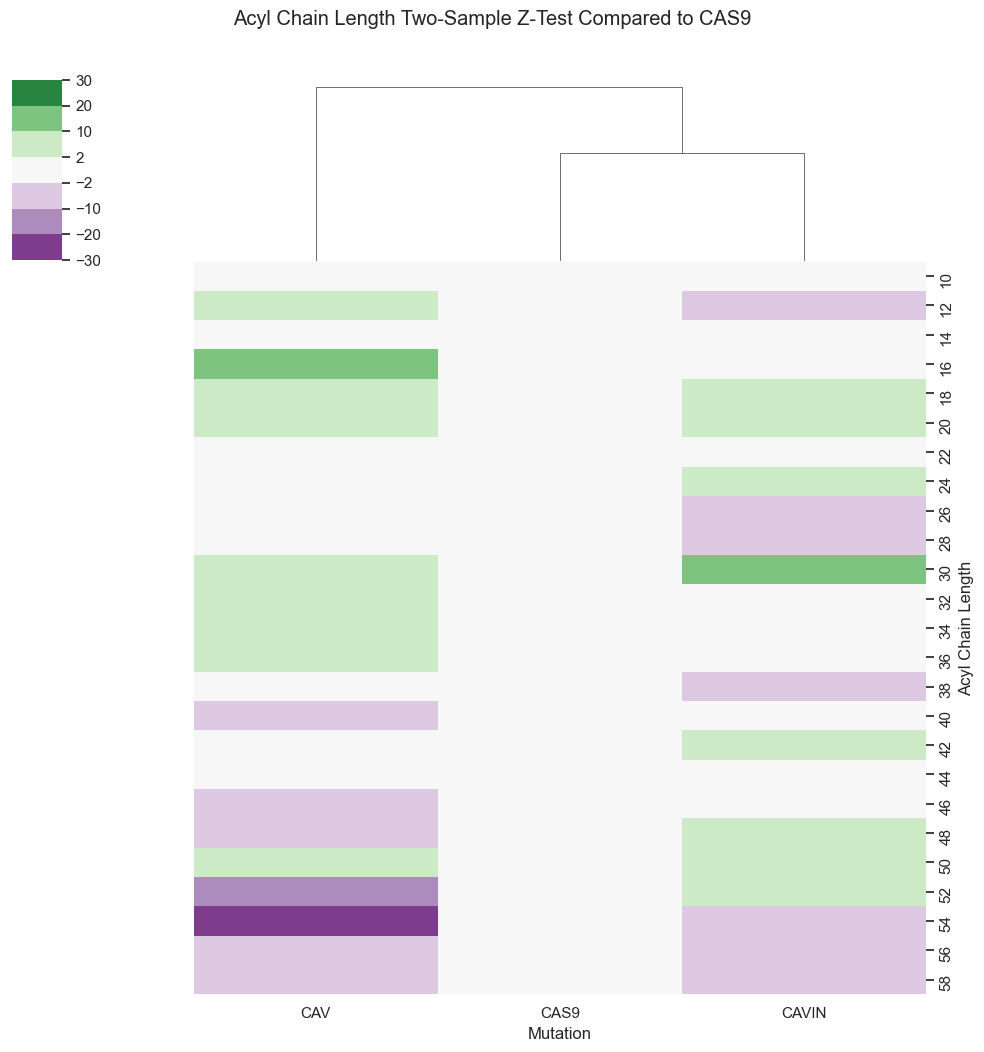

In [33]:
cl_z = functions.z_score(df_meta2,
                         df_ccc,
                         var = 'Acyl Chain Length',
                         drop_var = list(range(1,70,2)),
                         ctrl = 'CAS9',
                         row_cluster=False,
                        outlier = False)

In [34]:
# cl_z.to_csv('graphs/cas_cav_cavin/chain_length/Z-ScoreTable_EvenCL.csv')
cl_z

Mutation,CAS9,CAV,CAVIN
Acyl Chain Length,,,
10,0.0,1.850614,1.000000
12,0.0,2.058892,-2.417556
14,0.0,1.000000,0.000000
16,0.0,13.880905,1.174215
18,0.0,4.137029,4.854092
20,0.0,7.624232,2.338959
22,0.0,1.748733,1.883769
24,0.0,1.899001,4.555361
26,0.0,0.483593,-2.386232


# Unsaturation Analysis

In [35]:
u2_long = functions.norm_long(df_meta2, df_ccc, var='Unsaturation 2', renamed_var= 'Unsaturation')
# u2_long.head()

## Bar Graph

In [36]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# make selection for KO protein
click = alt.selection_point(fields=['Mutation'])

# grouped bar graph
g = alt.Chart(u2_long).mark_bar().encode(
    x=alt.X('Unsaturation:O').axis(labelAngle=0),
    xOffset='Mutation:N',
    y='mean(Fraction):Q',
    color=alt.condition(click, alt.Color('Mutation:N').scale(range=colors), alt.value('lightgray')),
    tooltip=['Mutation', 'Unsaturation', 'mean(Fraction)']
).add_params(
    click
).properties(
    width=800,
    title='Unsaturation Distribution'
)

# error bars
err = alt.Chart(u2_long).mark_errorbar(extent='stdev').encode(
    x='Unsaturation:O',
    xOffset='Mutation:N',
    y='mean(Fraction):Q',
)

ub = (g + err).configure(background='white')
ub.save('graphs/cas_cav_cavin/unsaturation/BarGraph_U.png', ppi=300)
ub

alt.LayerChart(...)

## Heatmap

In [37]:
hu = alt.Chart(u2_long).mark_rect(stroke='white').encode(
    x='Mutation:N',
    y='Unsaturation:O',
    color='mean(Fraction):Q',
    tooltip=['Mutation', 'Unsaturation', 'mean(Fraction)']
).properties(
    title='Unsaturation Distribution',
    width=400,
    height=400 
)
hu.save('graphs/cas_cav_cavin/unsaturation/Heatmap_U.png', ppi=300)
hu

alt.Chart(...)

## Z-Score

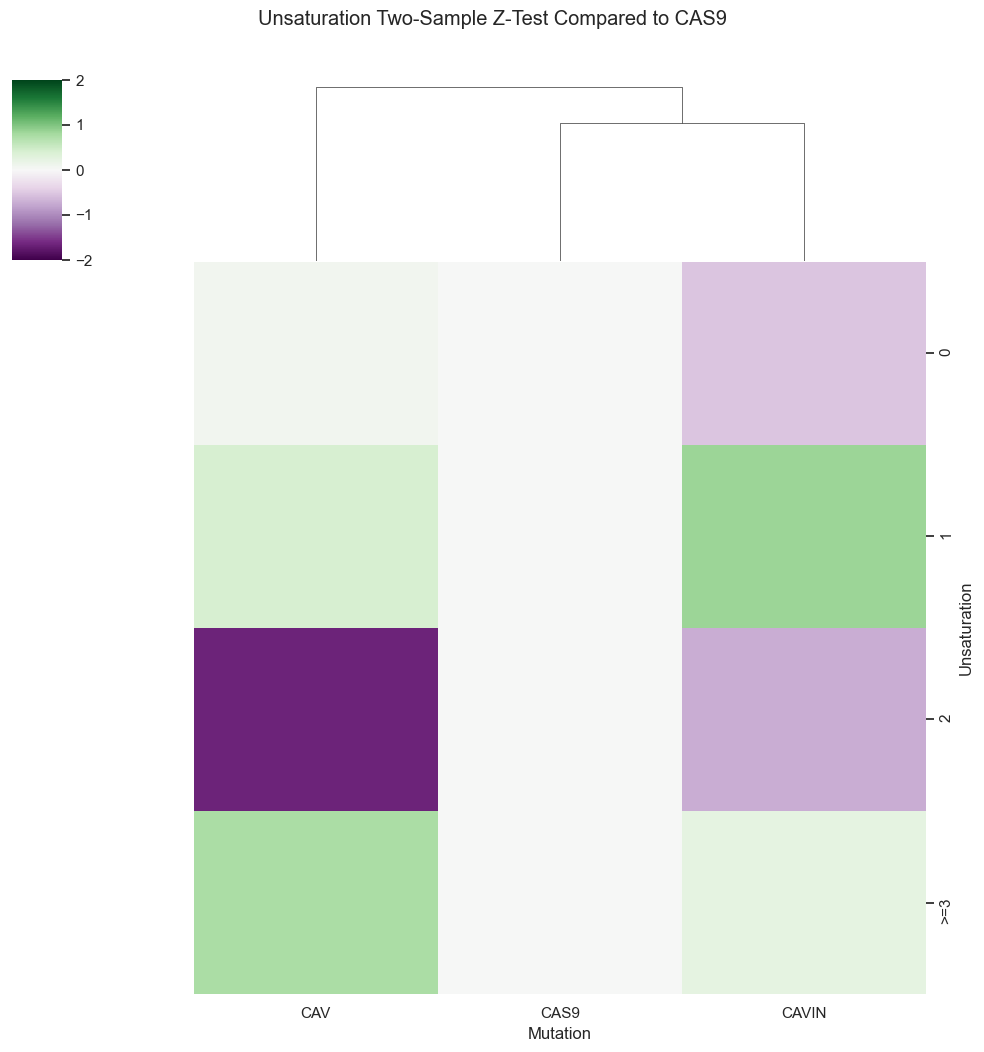

In [38]:
u_z = functions.z_score(df_meta2,
                         df_ccc,
                         var = 'Unsaturation 2',
                        renamed_var = 'Unsaturation',
                         ctrl = 'CAS9',
                         row_cluster=False)

In [39]:
# u_z.to_csv('graphs/cas_cav_cavin/unsaturation/Z-ScoreTable_U.csv', ppi=300)
u_z

Mutation,CAS9,CAV,CAVIN
Unsaturation,,,
0,0.0,0.087663,-0.529321
1,0.0,0.418678,0.843919
2,0.0,-1.667467,-0.732897
>=3,0.0,0.756478,0.240632
